In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
from pandas._libs.tslibs import timestamps
from datetime import datetime
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pymysql
from  sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
import joblib
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
Axes3D = Axes3D  # pycharm auto import
#Import the Keras libraries and packages
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [4]:
mydb=pymysql.connect(host='localhost',port=int(3306),user='root',passwd='',db='sensor_data') 
#waterlevel range 1
query1 = "Select cast(timestamp as char) as Date, cast(thingName as char) as waterLevel, ROW_NUMBER() OVER (ORDER BY id) row_num , cast(value as char) as water_value  FROM sensor_data WHERE thingName ='NIVÅ015'  AND data_type='waterLevelMmAdjustedRH2000';"
df1 = pd.read_sql(query1,mydb)
#print(df1)
#sea level
query2 = "Select cast(thingName as char) as seaLevel,ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as sea_value FROM sensor_data WHERE thingName BETWEEN 'NIVÅ015' AND 'NIVÅ016' AND data_type='waterLevelMmAdjustedRH2000';"
df2 = pd.read_sql(query2,mydb)
#print(df2)
#ground water
query3 = "Select  cast(thingName as char) as groundLevel, ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as ground_value,smhi_rain  FROM sensor_data WHERE data_type='waterLevel';"
df3 = pd.read_sql(query3,mydb)

In [5]:
#Separate dates for future plotting
df1["Date"] = pd.to_datetime(df1["Date"])
train_dates = df1["Date"] 

print(train_dates)
#print(train_dates.tail(15))#Check last few dates. 
 
df1_1=pd.DataFrame(df1[["row_num","waterLevel","water_value"]])
df2_2=pd.DataFrame(df2[["row_num","seaLevel","sea_value"]])
df3_3=pd.DataFrame(df3[["row_num","groundLevel","ground_value","smhi_rain"]])
#print reading result
print(df1_1)
print(df2_2)
print(df3_3)
# concatniting data
#dataframe=[df3_3,df2_2,df1_1]
#df1.merge(df2_2,how='left', left_on='Column1', right_on='ColumnA')
df=pd.merge(df3_3,df1_1, on='row_num')
df_last=pd.merge(df,df2_2, on='row_num')
print(df_last)

 # x, y with sklearn convert to nump.ndarray
df_last = df_last[["water_value","smhi_rain","sea_value","ground_value"]].to_numpy()# here we have 4 variables for multiple regression. 
#y = df_last[["water_value"]].to_numpy() 
#df_last=pd.merge(x,y, on="row_num")
    #print(x)
print(df_last)

0      2021-05-28 23:54:16
1      2021-05-28 22:57:20
2      2021-05-28 22:01:58
3      2021-05-28 20:50:48
4      2021-05-28 19:50:53
               ...        
1617   2021-08-04 06:01:10
1618   2021-08-04 05:01:06
1619   2021-08-04 03:51:11
1620   2021-08-04 01:59:58
1621   2021-08-04 01:00:44
Name: Date, Length: 1622, dtype: datetime64[ns]
      row_num waterLevel water_value
0           1    Nivå015         115
1           2    Nivå015         144
2           3    Nivå015         110
3           4    Nivå015         140
4           5    Nivå015         123
...       ...        ...         ...
1617     1618    Nivå015         168
1618     1619    Nivå015         172
1619     1620    Nivå015         161
1620     1621    Nivå015         165
1621     1622    Nivå015         193

[1622 rows x 3 columns]
      row_num seaLevel sea_value
0           1  Nivå016        79
1           2  Nivå016       103
2           3  Nivå016       111
3           4  Nivå016       134
4           5  Nivå01

In [6]:
# normalize the dataset
scaler = StandardScaler()
scaler=scaler.fit(df_last)
df_x=scaler.transform(df_last)
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
#print(x_train)

In [7]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 4. We will make timesteps = 15 (past days data used for training). 

#Empty lists to be populated using formatted training data
x_train = []
y_train = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#the df_x has a shape (3208, 4)
#3208 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(df_x) - n_future +1):
    x_train.append(df_x[i - n_past:i, 0:df_x.shape[1]])
    y_train.append(df_x[i + n_future - 1:i + n_future, 0])

x_train,y_train = np.array(x_train), np.array(y_train)

print(x_train)
print(y_train)
print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

[[[ 5.17003504e-02  4.93826924e-01 -1.16507563e-01 -5.22033641e-01]
  [ 3.37232942e-01  4.93826924e-01  1.29367229e-01 -5.22033641e-01]
  [ 2.47059324e-03  4.93826924e-01  2.11325493e-01 -5.22033641e-01]
  ...
  [-5.09518881e-01  4.93826924e-01  2.52304625e-01 -5.22033641e-01]
  [-5.88286493e-01  4.93826924e-01  5.49403332e-01 -5.22033641e-01]
  [-7.62970182e-02  4.93826924e-01  2.01080710e-01 -5.22033641e-01]]

 [[ 3.37232942e-01  4.93826924e-01  1.29367229e-01 -5.22033641e-01]
  [ 2.47059324e-03  4.93826924e-01  2.11325493e-01 -5.22033641e-01]
  [ 2.97849136e-01  4.93826924e-01  4.46955502e-01 -5.22033641e-01]
  ...
  [-5.88286493e-01  4.93826924e-01  5.49403332e-01 -5.22033641e-01]
  [-7.62970182e-02  4.93826924e-01  2.01080710e-01 -5.22033641e-01]
  [ 2.19081525e-01  4.93826924e-01  5.08424200e-01 -5.22033641e-01]]

 [[ 2.47059324e-03  4.93826924e-01  2.11325493e-01 -5.22033641e-01]
  [ 2.97849136e-01  4.93826924e-01  4.46955502e-01 -5.22033641e-01]
  [ 1.30467962e-01  4.93826924e-

In [8]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
91/91 [==============================] - 84s 30ms/step - loss: 0.5084 - mean_squared_error: 0.5084 - mean_absolute_error: 0.5446 - mean_absolute_percentage_error: 162.2986 - val_loss: 0.9472 - val_mean_squared_error: 0.9472 - val_mean_absolute_error: 0.6776 - val_mean_absolute_percentage_error: 119.5735
Epoch 2/5
91/91 [==============================] - 1s 13ms/step - loss: 0.2622 - mean_squared_error: 0.2622 - mean_absolute_error: 0.3797 - mean_absolute_percentage_error: 154.6563 - val_loss: 1.2993 - val_mean_squared_error: 1.2993 - val_mean_absolute_error: 0.8702 - val_mean_absolute_percentage_error: 337.0788
Epoch 3/5
91/91 [==============================] - 1s 13ms/step - loss: 0.2000 - mean_squared_error: 0.2000 - mean_absolute_error: 0.3320 - mean_absolute_percentage_error: 112.7666 - val_loss: 0.4925 - val_mean_squared_error: 0.4925 - val_mean_absolute_error: 0.5316 - val_mean_absolute_percentage_error: 245.4629
Epoch 4/5
91/91 [==============================] - 1s 11m

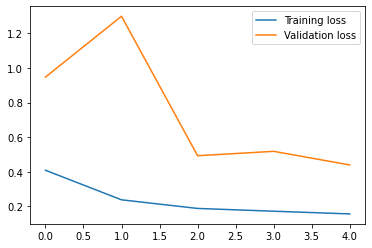

In [9]:
# fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

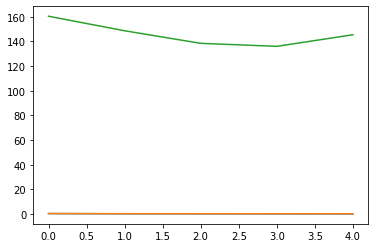

In [10]:
# plot metrics
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])

plt.show()

        Date  Water_Level_last
0 2021-09-12        244.998260
1 2021-09-13        219.452164
2 2021-09-14        200.100998
3 2021-09-15        180.964706
4 2021-09-16        171.947830
5 2021-09-17        166.974792
6 2021-09-18        167.893250
                    Date water_value
1615 2021-08-04 08:01:05         199
1616 2021-08-04 06:51:43         192
1617 2021-08-04 06:01:10         168
1618 2021-08-04 05:01:06         172
1619 2021-08-04 03:51:11         161
1620 2021-08-04 01:59:58         165
1621 2021-08-04 01:00:44         193


C:\Users\alha1207\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Water_Level_last'>

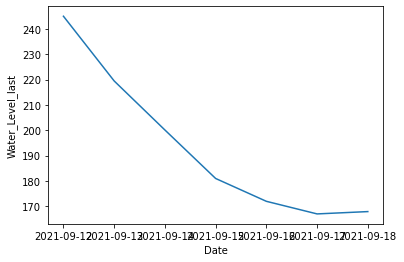

In [11]:
n_future=7
#n_past = 16
#n_days_for_prediction=15
#print(train_dates)
#train_dates=pd.to_datetime(pd.Series(df1["Date"]))
#print(train_dates)
#list(train_dates)[-1]
forecast_period_dates = pd.date_range(start=datetime.now(), periods=n_future, freq='1D').tolist()
#print(forecast_period_dates)
#predict the next 7 days
#print(x_train)
forecast = model.predict(x_train[-n_future:])
#print(forecast)
forecast_copies =np.repeat(forecast, df_last.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
#print(forecast_copies)
#print(y_pred_future)
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Water_Level_last':y_pred_future})
df_forecast["Date"]=pd.to_datetime(df_forecast["Date"])
print(df_forecast)

original = df1[["Date","water_value"]]
original = original.tail(7)
print(original)
#original["Date"]=df1["Date"]
#original = original.loc[original["Date"] >= '2021-8-4']
#print(original)
#sns.set(rc={'figure.figsize':(8,8)})
#sns.lineplot(original["Date"], original["water_value"])
sns.lineplot(df_forecast["Date"], df_forecast["Water_Level_last"])


In [12]:
#test values
predicted_waterLevel = df_forecast["Water_Level_last"] 
print("Water Level for next 7 days :\n",df_forecast) 
for i in predicted_waterLevel:
    if(i > 900): 
         print("Will flood soon") 
    else:
         print("Water level is OK") 
dir='C:\\Users\\alha1207\\ANN\\output\\'
filename ='ANN_model_4.sav' 
joblib.dump(predicted_waterLevel, dir + filename)

Water Level for next 7 days :
         Date  Water_Level_last
0 2021-09-12        244.998260
1 2021-09-13        219.452164
2 2021-09-14        200.100998
3 2021-09-15        180.964706
4 2021-09-16        171.947830
5 2021-09-17        166.974792
6 2021-09-18        167.893250
Water level is OK
Water level is OK
Water level is OK
Water level is OK
Water level is OK
Water level is OK
Water level is OK


['C:\\Users\\alha1207\\ANN\\output\\ANN_model_4.sav']

In [13]:
## database cloding 
mydb.close() #close the connection
print("Database closed!")

Database closed!
